# Jeu de données avec des catégories

Le jeu de données [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) ne contient presque que des catégories. Ce notebook explore différentes moyens de les traiter.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## données

In [3]:
from papierstat.datasets import load_adult_dataset
train, test = load_adult_dataset(url="copy")
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
label = '<=50K'
set(train[label])

{'<=50K', '>50K'}

In [5]:
set(test[label])

{'<=50K', '>50K'}

In [6]:
X_train = train.drop(label, axis=1)
y_train = train[label] == '>50K'
X_test = test.drop(label, axis=1)
y_test = test[label] == '>50K'

In [7]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
<=50K             object
dtype: object

La variable *fnlwgt* représente une forme de pondération : le nombre d'individus que chaque observation représente. Elle ne doit pas servir à la prédiction, comme pondération qu'on ignorera.

In [8]:
X_train = X_train.drop(['fnlwgt'], axis=1).copy()
X_test = X_test.drop(['fnlwgt'], axis=1).copy()

## catégories

On garde la liste des variables catégorielles.

In [9]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

La fonction [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) est pratique mais problématique si les modalités de la base d'apprentissage et la base de test sont différentes, ce qui est fréquemment le cas pour les catégories peu fréquentes. On veut utiliser [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) mais ce n'est pas très pratique.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pipe = make_pipeline(LabelEncoder(), OneHotEncoder())
try:
    pipe.fit(X_train[cat_col[0]], y_train)
except Exception as e:
    print(e)

fit_transform() takes 2 positional arguments but 3 were given


On utilise [OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/).

In [11]:
from category_encoders import OneHotEncoder
ce = OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error')
X_train_cat = ce.fit_transform(X_train)
X_train_cat.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


C'est assez compliqué à lire. Le code suivant ne produit pas toujours un résultat correct si ``drop_invariant=False``.

In [12]:
cols = []
for co in X_train.columns:
    if co in cat_col:
        ind = cat_col.index(co)
        mapping = ce.category_mapping[ind]['mapping']
        for m in mapping:
            cols.append(co + "/" + m[0].strip())
X_train_cat.columns = cols + list(X_train_cat.columns)[len(cols):]
X_train_cat.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


## premier jet

On construit un pipeline.

In [13]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(
            OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error'), 
            LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('logisticregression', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [14]:
pipe.score(X_test, y_test)

0.8516061666973773

On essaye avec une [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [15]:
from sklearn.ensemble import RandomForestClassifier
pipe2 = make_pipeline(ce, RandomForestClassifier(n_estimators=100))
pipe2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
pipe2.score(X_test, y_test)

0.8460782507217002

In [17]:
pipe2.steps[-1][-1].feature_importances_[:5]

array([0.00530061, 0.0094053 , 0.01143918, 0.00547224, 0.00642466])

On regarde l'importance des features.

In [18]:
import pandas
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe2.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
df.head()

,importance
name,
age,0.227413
hours_per_week,0.112709
capital_gain,0.107966
education_num,0.068386
marital_status/Married-civ-spouse,0.057291


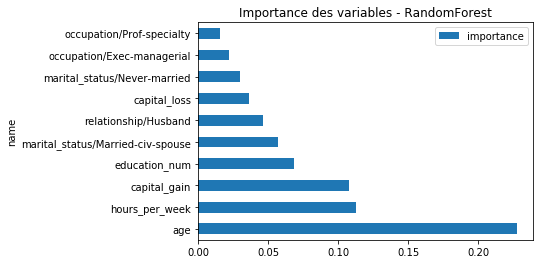

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - RandomForest');

On compare avec [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html).

In [20]:
from xgboost import XGBClassifier
pipe3 = make_pipeline(ce, XGBClassifier())
pipe3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('xgbclassifier', XGBClassifier(base...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [21]:
pipe3.score(X_test, y_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.869172655242307

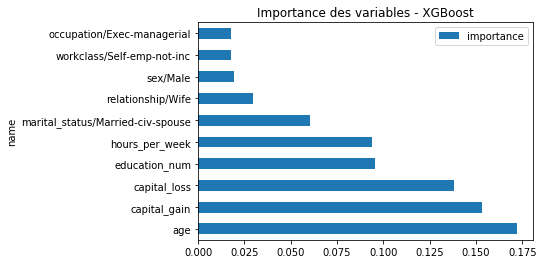

In [22]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe3.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - XGBoost');

On retrouve presque les mêmes variables mais pas dans le même ordre. On essaye un dernier module [catboost](https://tech.yandex.com/catboost/).

In [23]:
from catboost import CatBoostClassifier
pipe4 = make_pipeline(ce, CatBoostClassifier(iterations=100, verbose=False))
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x000001669C10FE48>)])

In [24]:
pipe4.score(X_test, y_test)

0.862600577360113

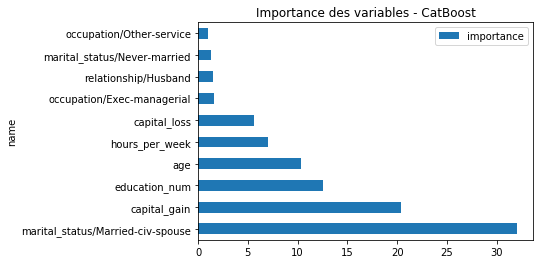

In [25]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe4.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - CatBoost');

## GridSearch

On cherche à optimiser les hyperparamètres sur la base d'apprentissage.

## Features polynômiales

In [27]:
from sklearn.preprocessing import PolynomialFeatures
pipe5 = make_pipeline(ce, PolynomialFeatures(), RandomForestClassifier())
pipe5.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('polynomialfeatures', PolynomialFea...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [28]:
pipe5.score(X_test, y_test)

0.843252871445243

Ca n'améliore pas.

## Interprétation

On souhaite en savoir plus sur les variables.

In [29]:
conc = pandas.concat([X_train_cat, y_train], axis=1)
conc.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week,<=50K
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,39,13,2174,0,40,False
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,50,13,0,0,13,False
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,38,9,0,0,40,False
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,53,7,0,0,40,False
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,28,13,0,0,40,False


In [30]:
corr = conc.corr()

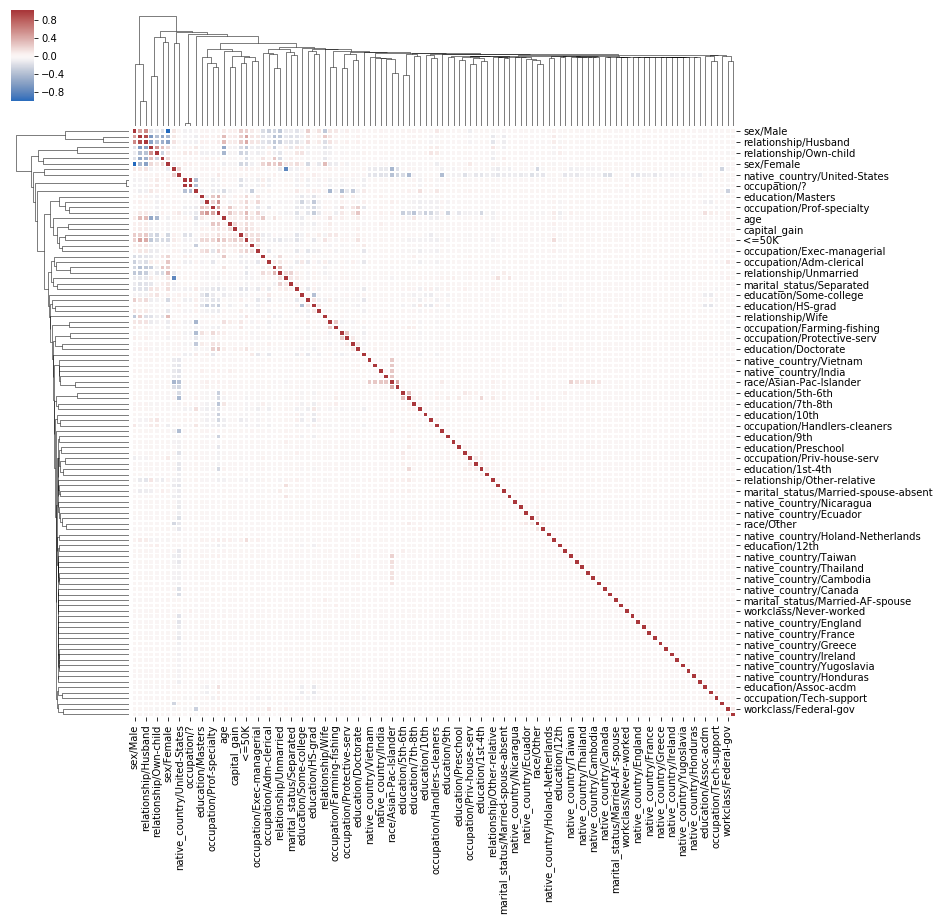

In [31]:
from seaborn import clustermap

clustermap(corr, center=0, cmap="vlag", linewidths=.75, figsize=(13, 13));

Ce n'est pas facile à voir. 

A finir.

## Analyse d'erreur

On recherche les erreurs les plus flagrantes, celles dont le score est élevé.

In [32]:
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)
pred2 = pipe2.predict(X_test)
proba2 = pipe2.predict_proba(X_test)
pred3 = pipe3.predict(X_test)
proba3 = pipe3.predict_proba(X_test)
pred4 = pipe4.predict(X_test)
proba4 = pipe4.predict_proba(X_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [33]:
data = pandas.concat([
            pandas.DataFrame(y_test.astype(float).as_matrix(), columns=['y_test']),
            pandas.DataFrame(pred, columns=['pred1']),
            pandas.DataFrame(proba[:,1], columns=['P1(>=50K)']),
            pandas.DataFrame(pred2, columns=['pred2']),
            pandas.DataFrame(proba2[:,1], columns=['P2(>=50K)']),
            pandas.DataFrame(pred3, columns=['pred3']),
            pandas.DataFrame(proba3[:,1], columns=['P3(>=50K)']),
            pandas.DataFrame(pred4, columns=['pred4']),
            pandas.DataFrame(proba4[:,1], columns=['P4(>=50K)']),
            X_test,
            ], axis=1)
data.head()

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.0,False,0.002997,False,0.010000,False,0.007642,0.0,0.008994,25,...,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,0.0,False,0.138880,False,0.085357,False,0.203497,0.0,0.291948,38,...,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,1.0,False,0.364649,True,0.572500,False,0.277167,0.0,0.306901,28,...,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,1.0,True,0.754975,True,0.950000,True,0.984138,1.0,0.956812,44,...,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,0.0,False,0.001904,False,0.000000,False,0.002210,0.0,0.006293,18,...,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [34]:
data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=False).head().T

,3605,4143,2926,786,13128
y_test,0,0,0,0,0
pred1,True,True,True,True,True
P1(>=50K),0.999997,0.927754,0.779498,0.844606,0.579247
pred2,True,True,True,True,True
P2(>=50K),0.79,0.92,0.72,0.86,0.62
pred3,True,True,True,True,True
P3(>=50K),0.972606,0.881992,0.900088,0.838751,0.913922
pred4,1,1,1,1,1
P4(>=50K),0.969082,0.940291,0.925571,0.919115,0.915543
age,36,64,65,67,48


Tous les modèles font l'erreur sur ces cinq exemples. Le modèle a toutes les raisons de décider que les personnes gagnent plus de 50k par an, beaucoup d'études, plutôt âge ou travaillant beaucoup.

In [35]:
data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head().T

,5953,10408,3059,11821,14757
y_test,1,1,1,1,1
pred1,False,False,False,False,False
P1(>=50K),0.00231258,0.00219724,0.0280105,0.0079481,0.0187709
pred2,False,False,False,False,False
P2(>=50K),0,0,0,0,0.03
pred3,False,False,False,False,False
P3(>=50K),0.00299048,0.00288558,0.00561586,0.00960333,0.0572303
pred4,0,0,0,0,0
P4(>=50K),0.00678726,0.0067991,0.0101678,0.0124197,0.0130638
age,20,22,22,24,25


Ceux-ci sont probablement étudiants et déjà aisés. Il faudrait avoir quelques informations sur les parents pour confirmer.

Recherche de plus proches voisins dans la base.